# Compress_attn

In [6]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from torch_code import torch_blcok_compress, torch_cmp_attn, flex_cmp_attn
from compress_attn import blcok_compress as triton_block_compress
from compress_attn import compress_attn as triton_compress_attn_v1
from compress_attn_v2 import compress_attn as triton_compress_attn_v2
from transformers import LlamaForCausalLM

## block_compress
- 目前这个版本weight是[kernel_size], pe是[kernel_size, v_head_dim / k_head_dim]

### 精度

In [3]:
device = 'cuda'
dtype = torch.bfloat16
# 论文中k的配置
b, h, n, d = 1, 4, 4096, 192
stride = 16
kernel_size = 32
x1 = torch.randn(b, n, h, d, device=device, dtype=dtype)
x1.requires_grad_(True)
weight1 = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
pe1 = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))
x2 = deepcopy(x1)
weight2 = deepcopy(weight1)
pe2 = deepcopy(pe1)
x3 = torch.randn(b, n, h, d, device=device, dtype=torch.float32)
x3.requires_grad_(True)
weight3 = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=torch.float32))
pe3 = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=torch.float32))
x3.data.copy_(x1.data)
weight3.data.copy_(weight1.data)
pe3.data.copy_(pe1.data)

y1 = torch_blcok_compress(x1, weight1, pe1, stride)
y2 = triton_block_compress(x2, weight2, pe2, stride)
y3 = torch_blcok_compress(x3, weight3, pe3, stride)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
y3.backward(dy.float())
print('='*50 + ' forward output:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(y1-y3).abs().max().item()}, 平均差值: {(y1-y3).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(y2-y3).abs().max().item()}, 平均差值: {(y2-y3).abs().mean().item()}')
print('='*50 + ' backward input grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(x1.grad-x3.grad).abs().max().item()}, 平均差值: {(x1.grad-x3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(x2.grad-x3.grad).abs().max().item()}, 平均差值: {(x2.grad-x3.grad).abs().mean().item()}')
print('='*50 + ' backward weight grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(weight1.grad-weight3.grad).abs().max().item()}, 平均差值: {(weight1.grad-weight3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(weight2.grad-weight3.grad).abs().max().item()}, 平均差值: {(weight2.grad-weight3.grad).abs().mean().item()}')
print('='*50 + ' backward pe grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(pe1.grad-pe3.grad).abs().max().item()}, 平均差值: {(pe1.grad-pe3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(pe2.grad-pe3.grad).abs().max().item()}, 平均差值: {(pe2.grad-pe3.grad).abs().mean().item()}')

================================================== forward output:
torch   bf16 vs torch fp32: 最大差值: 0.20862579345703125, 平均差值: 0.022884361445903778
triton  bf16 vs torch fp32: 最大差值: 0.12482452392578125, 平均差值: 0.01120144035667181
================================================== backward input grad:
torch   bf16 vs torch fp32: 最大差值: 0.01727294921875, 平均差值: 0.00157164316624403
triton  bf16 vs torch fp32: 最大差值: 0.0078125, 平均差值: 0.0010277547407895327
================================================== backward weight grad:
torch   bf16 vs torch fp32: 最大差值: 56.013671875, 平均差值: 8.716752052307129
triton  bf16 vs torch fp32: 最大差值: 56.013671875, 平均差值: 8.567572593688965
================================================== backward pe grad:
torch   bf16 vs torch fp32: 最大差值: 4.180908203125, 平均差值: 0.731353759765625
triton  bf16 vs torch fp32: 最大差值: 3.99853515625, 平均差值: 0.7305139303207397


### forward

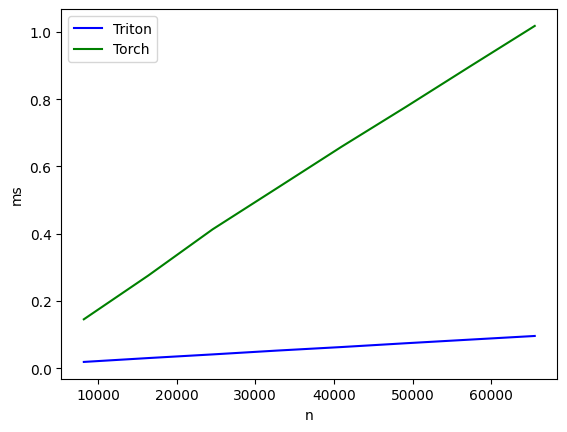

forward:
         n    Triton     Torch
0   8192.0  0.018637  0.145369
1  16384.0  0.030112  0.275428
2  24576.0  0.040990  0.412948
3  32768.0  0.052366  0.535446
4  40960.0  0.062871  0.658381
5  49152.0  0.074192  0.776901
6  57344.0  0.085014  0.897856
7  65536.0  0.095806  1.017664


In [2]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'h':4, 'd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, provider, h, n, d, stride, kernel_size):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n, h, d, device=device, dtype=dtype)
    weight = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
    pe = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_blcok_compress(x, weight, pe, stride))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_block_compress(x, weight, pe, stride))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

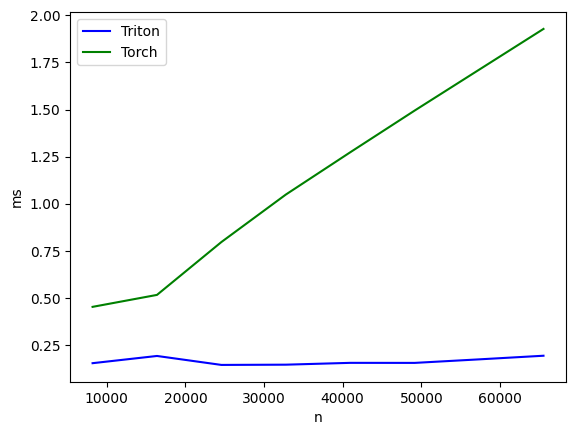

backward:
         n    Triton     Torch
0   8192.0  0.154183  0.453055
1  16384.0  0.192495  0.516526
2  24576.0  0.144959  0.797048
3  32768.0  0.146263  1.048884
4  40960.0  0.155951  1.273290
5  49152.0  0.155707  1.494620
6  57344.0  0.174456  1.711335
7  65536.0  0.193731  1.927839


In [2]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'h':4, 'd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, provider, h, n, d, stride, kernel_size):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n, h, d, device=device, dtype=dtype)
    x.requires_grad_(True)
    weight = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
    pe = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        y = torch_blcok_compress(x, weight, pe, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x, weight, pe])
    if provider == 'triton':
        y = triton_block_compress(x, weight, pe, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x, weight, pe])
    return ms
benchmark.run(show_plots=True, print_data=True)

## attention
- 对比三种实现方式

### 精度

In [ ]:
n = 8192 
kernel_size = 32
stride = 16
select_size = 64
# flex_attn必须要head_dim是2的指数倍
b, qh, kh, d, vd = 1, 64, 4, 128, 128
device = 'cuda'
dtype = torch.float16
num_blocks = (n - kernel_size) // stride + 1
q1 = torch.randn(b, n, qh, d, device=device, dtype=dtype)
ck1 = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
cv1 = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
q1.requires_grad_(True)
ck1.requires_grad_(True)
cv1.requires_grad_(True)
q2 = deepcopy(q1)
ck2 = deepcopy(ck1)
cv2 = deepcopy(cv1)
q3 = deepcopy(q1)
ck3 = deepcopy(ck1)
cv3 = deepcopy(cv1)

In [8]:
y1 = torch_cmp_attn(q1, ck1, cv1, kernel_size, stride)

y3, lse3 = triton_compress_attn_v1(q3, ck3, cv3, kernel_size, stride)

# dy12不是连续的，dy3要求是连续的
dy12 = torch.randn_like(y1)
dy3 = torch.rand_like(y3)
dy3.data.copy_(dy12)

y1.backward(dy12)

y3.backward(dy3)

print('='*10 + ' triton vs torch')
print((y1-y3).abs().max().item(), '\t',(y1-y3).abs().mean().item())
print((q1.grad-q3.grad).abs().max().item(), '\t',(q1.grad-q3.grad).abs().mean().item())
print((ck1.grad-ck3.grad).abs().max().item(),'\t', (ck1.grad-ck3.grad).abs().mean().item())
print((cv1.grad-cv3.grad).abs().max().item(),'\t', (cv1.grad-cv3.grad).abs().mean().item())
# 由于是GQA，kv梯度进行bf16的累加，如果是fp32或者fp16会减少误差
if math.log2(d).is_integer():
    y2 = flex_cmp_attn(q2, ck2, cv2, kernel_size, stride)
    y2.backward(dy12)
    print('='*10 + ' triton vs flex')
    print((y2-y3).abs().max().item(), '\t',(y2-y3).abs().mean().item())
    print((q2.grad-q3.grad).abs().max().item(), '\t',(q2.grad-q3.grad).abs().mean().item())
    print((ck2.grad-ck3.grad).abs().max().item(), '\t',(ck2.grad-ck3.grad).abs().mean().item()) 
    print((cv2.grad-cv3.grad).abs().max().item(), '\t',(cv2.grad-cv3.grad).abs().mean().item())

========== triton vs torch
0.00244140625 	 5.745887756347656e-05
0.00390625 	 5.728006362915039e-05
0.0234375 	 0.0009217262268066406
0.03125 	 0.0009174346923828125
========== triton vs flex
0.001953125 	 4.494190216064453e-05
0.00390625 	 5.418062210083008e-05
0.029296875 	 0.0008544921875
0.03125 	 0.0007448196411132812


### foward

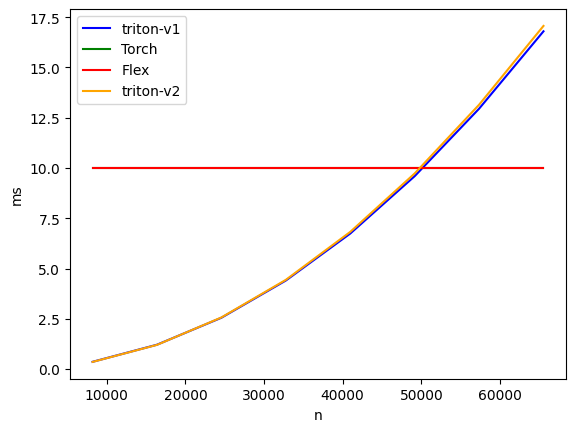

forward:
         n  triton-v1  Torch  Flex  triton-v2
0   8192.0   0.360411   10.0  10.0   0.355078
1  16384.0   1.211104   10.0  10.0   1.203133
2  24576.0   2.552417   10.0  10.0   2.566982
3  32768.0   4.402770   10.0  10.0   4.436821
4  40960.0   6.739471   10.0  10.0   6.822478
5  49152.0   9.593306   10.0  10.0   9.728149
6  57344.0  12.949540   10.0  10.0  13.147432
7  65536.0  16.799526   10.0  10.0  17.067423


In [5]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'flex', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "Torch",
            "Flex",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n - kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    cv = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n > 4096:
            return 10
        ms = triton.testing.do_bench(lambda: torch_cmp_attn(q, ck, cv, kernel_size, stride))
    if provider == 'triton-v1':
        ms = triton.testing.do_bench(lambda: triton_compress_attn_v1(q, ck, cv, kernel_size, stride))
    if provider == 'flex':
        if n > 4096:
            return 10
        if not math.log2(d).is_integer():
            return 10
        ms = triton.testing.do_bench(lambda: flex_cmp_attn(q, ck, cv, kernel_size, stride))
    if provider == 'triton-v2':
        ms = triton.testing.do_bench(lambda: triton_compress_attn_v2(q, ck, cv, kernel_size, stride))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

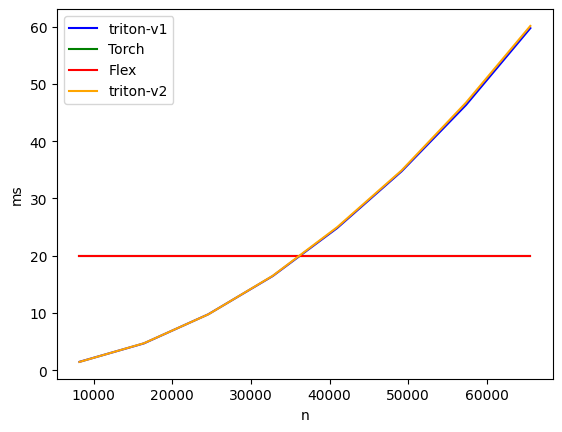

backward:
         n  triton-v1  Torch  Flex  triton-v2
0   8192.0   1.468365   20.0  20.0   1.453358
1  16384.0   4.689148   20.0  20.0   4.708893
2  24576.0   9.772910   20.0  20.0   9.762478
3  32768.0  16.450586   20.0  20.0  16.493933
4  40960.0  24.828651   20.0  20.0  24.978943
5  49152.0  34.734112   20.0  20.0  34.892048
6  57344.0  46.322624   20.0  20.0  46.735138
7  65536.0  59.762367   20.0  20.0  60.145855


In [6]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'flex', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "Torch",
            "Flex",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d,vd, stride, kernel_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n - kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    cv = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    ck.requires_grad_(True)
    cv.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n > 4096:
            return 20
        y = torch_cmp_attn(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'triton-v1':
        y, _ = triton_compress_attn_v1(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'triton-v2':
        y, _ = triton_compress_attn_v2(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'flex':
        if n > 4096:
            return 20
        if not math.log2(d).is_integer():
            return 10
        y = flex_cmp_attn(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    return ms
benchmark.run(show_plots=True, print_data=True)

# Select_attn

In [1]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from torch_code import torch_select_for_fwd, torch_select_attn
from select_attn import select_for_fwd_bwd
from select_attn import select_attn as triton_select_attn_v1
from select_attn_v2 import select_attn as triton_select_attn_v2
from select_attn_v3 import select_attn as triton_select_attn_v3
# from exp_family import _attention, select_attn

## select

In [2]:
n = 8192
kernel_size = 32
stride = 16
select_size = 64
top_n = 16
# flex_attn必须要head_dim是2的指数倍
b, qh, kh, d, vd = 1, 64, 4, 128, 128
device = 'cuda'
dtype = torch.bfloat16
num_blocks = (n - kernel_size) // stride + 1
q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 4

In [3]:
p1, ind1 = torch_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)
# select操作是不可导的，写前向就行了
p2, ind2 = triton_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n, return_p=True)
print((p1 - p2).abs().max(), (p1 - p2).abs().mean())
print(((p1 - p2).abs() / (p2.abs() + 1e-3)).mean())

tensor(1., device='cuda:0') tensor(0.0085, device='cuda:0')
tensor(0.0003, device='cuda:0')


In [4]:
print(triton.testing.do_bench(lambda: torch_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)))
print(triton.testing.do_bench(lambda: triton_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)))

45.77288055419922
0.2832818627357483


In [5]:
# 下面这两个不一定完全一样，p的小误差，可能选的就不一样, 大致差不多
# 128类似-100，表示不选，比如[0, 63]最多就选一个block
print(ind1[0, 0])
print(ind2[0, 0])

tensor([[  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        ...,
        [127,  56,  12,  ...,  64, 111,  48],
        [127,  46,   3,  ..., 123,   4,  66],
        [127,   7,   1,  ...,  94,  80,  73]], device='cuda:0')
tensor([[  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        ...,
        [127,  56,  12,  ...,  64, 111,  48],
        [127,  46,   3,  ..., 123,   4,  37],
        [127,   7,   1,  ...,  80,  94,  73]], device='cuda:0',
       dtype=torch.int32)


In [6]:
# 用于attention反向传播，bwd_ind表示kv block被哪个q选了，count表示个数
bwd_ind, counts = select_for_bwd(ind2)
print(bwd_ind[0, 0])
print(counts[0,0])

tensor([[   0,    1,    2,  ..., 8189, 8190, 8191],
        [  64,   65,   66,  ..., 8189, 8190, 8191],
        [ 128,  129,  130,  ..., 8188, 8189, 8190],
        ...,
        [8064, 8065, 8066,  ..., 8189, 8190, 8191],
        [8128, 8129, 8130,  ..., 8125, 8126, 8127],
        [   0,    1,    2,  ..., 8189, 8190, 8191]], device='cuda:0')
tensor([1861, 2490, 3578, 3055, 2593, 2720, 3240, 1814, 2708, 3632, 2351, 2366,
        1774, 1797, 2781, 2029, 2265, 1761, 1310, 2753, 1575, 1521, 1557, 1926,
         890, 1945, 1222, 1114, 2090, 1253, 2156, 1297, 1145, 1327, 1843, 1747,
        1139,  601, 1713, 1748, 1328,  749, 1294, 1503,  828, 1237,  555,  776,
         734,  960, 1198,  742, 1002,  677,  916, 1539,  805, 1046,  668,  525,
        1249,  500,  768,  449, 1122,  646,  328,  506,  719,  384,  524,  567,
         601, 1010,  649,  450,  467,  648,  526,  290,  703,  319,  641,  674,
         437,  329,  504,  454,  512,  310,  295,  289,  207,  271,  363,  474,
         409,  36

## attention

### 精度测试

In [6]:
n = 8192
kernel_size = 32
stride = 16
select_size = 64
top_n = 16
b, qh, kh, d, vd = 1, 64, 4, 128, 128
device = 'cuda'
dtype = torch.float16
num_blocks = (n-kernel_size) // stride + 1
q1 = torch.randn(b, n, qh, d, device=device, dtype=dtype)
k1 = torch.randn(b, n, kh, d, device=device, dtype=dtype)
v1 = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
q1.requires_grad_(True)
k1.requires_grad_(True)
v1.requires_grad_(True)
q2 = deepcopy(q1)
k2 = deepcopy(k1)
v2 = deepcopy(v1)
ck1 = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10
_, fwd_ind, bwd_ind = select_for_fwd_bwd(q1, ck1, lse, kernel_size, stride, select_size, top_n)

In [12]:

y1 = torch_select_attn(q1, k1, v1, select_size, fwd_ind.to(torch.int64))
y2 = triton_select_attn_v3(q2, k2, v2, select_size, fwd_ind, bwd_ind, inplace=False)
dy1 = torch.randn_like(y1)
dy2 = torch.randn_like(y2)
dy2.data.copy_(dy1)
y1.backward(dy1)
y2.backward(dy2)
print('='*10 + ' triton vs torch')
print((y1-y2).abs().max().item(), (y1-y2).abs().mean().item())
print((q1.grad-q2.grad).abs().max().item(), (q1.grad-q2.grad).abs().mean().item())
print((k1.grad-k2.grad).abs().max().item(), (k1.grad-k2.grad).abs().mean().item())
print((v1.grad-v2.grad).abs().max().item(), (v1.grad-v2.grad).abs().mean().item())

========== triton vs torch
0.0029296875 3.039836883544922e-05
0.0078125 9.512901306152344e-05
0.03125 0.00036025047302246094
0.03125 0.00034499168395996094


### forward

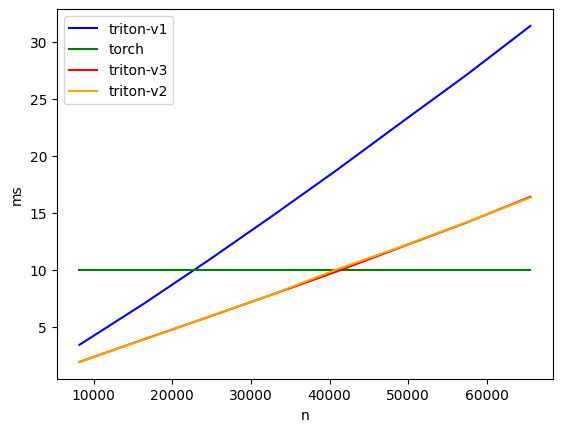

forward:
         n  triton-v1  torch  triton-v3  triton-v2
0   8192.0   3.394512   10.0   1.897318   1.894896
1  16384.0   7.006057   10.0   3.872566   3.852431
2  24576.0  10.798994   10.0   5.835634   5.848036
3  32768.0  14.728879   10.0   7.819782   7.832922
4  40960.0  18.751648   10.0   9.842164  10.023431
5  49152.0  22.916727   10.0  11.980547  12.023136
6  57344.0  27.038763   10.0  14.101783  14.130798
7  65536.0  31.376106   10.0  16.385237  16.313532


In [10]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'triton-v3', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "torch",
            "triton-v3",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n-kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 4
    _, fwd_ind, bwd_ind = select_for_fwd_bwd(q, ck, lse, kernel_size, stride, select_size, top_n)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n > 4096:
            return 10
        ms = triton.testing.do_bench(lambda: torch_select_attn(q, k, v, select_size, fwd_ind))
        # ms = triton.testing.do_bench(lambda: select_attn(q, k, v, select_size, ind))
    if provider == 'triton-v1':
        # return 10
        ms = triton.testing.do_bench(lambda: triton_select_attn_v1(q, k, v, select_size, fwd_ind, bwd_ind))
    if provider == 'triton-v2':
        # return 10
        ms = triton.testing.do_bench(lambda: triton_select_attn_v2(q, k, v, select_size, fwd_ind, bwd_ind))
    if provider == 'triton-v3':
        # return 10
        ms = triton.testing.do_bench(lambda: triton_select_attn_v3(q, k, v, select_size, fwd_ind, bwd_ind))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

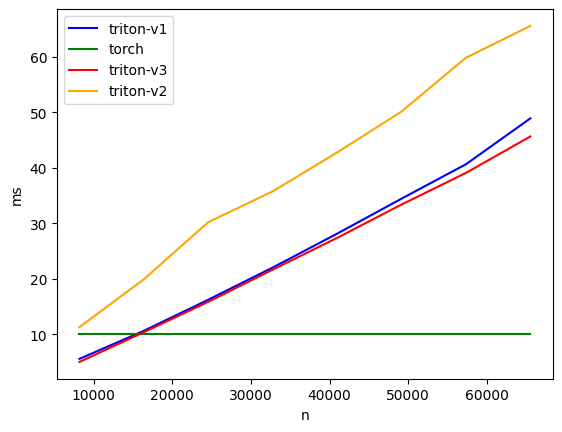

forward:
         n  triton-v1  torch  triton-v3  triton-v2
0   8192.0   5.547436   10.0   4.999887  11.269884
1  16384.0  10.607917   10.0  10.368139  19.888527
2  24576.0  16.205456   10.0  15.833734  30.186966
3  32768.0  22.001801   10.0  21.624271  35.729713
4  40960.0  28.110037   10.0  27.348577  42.742847
5  49152.0  34.417793   10.0  33.358147  50.118591
6  57344.0  40.619217   10.0  39.057457  59.812576
7  65536.0  48.890701   10.0  45.623886  65.544701


In [2]:
#bwd_ind会被原地修改,得制止下
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'triton-v3', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "torch",
            "triton-v3",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n-kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    k.requires_grad_(True)
    v.requires_grad_(True)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10
    _, fwd_ind, bwd_ind = select_for_fwd_bwd(q, ck, lse, kernel_size, stride, select_size, top_n)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n>4096:
            return 10
        y = torch_select_attn(q, k, v, select_size, fwd_ind.long())
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'triton-v1':
        y = triton_select_attn_v1(q, k, v, select_size, fwd_ind, bwd_ind, inplace=False)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'triton-v2':
        y = triton_select_attn_v2(q, k, v, select_size, fwd_ind, bwd_ind, inplace=False)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'triton-v3':
        y = triton_select_attn_v3(q, k, v, select_size, fwd_ind, bwd_ind, inplace=False)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    return ms
benchmark.run(show_plots=True, print_data=True)

# Combine

In [1]:
import torch
import triton
import triton.language as tl
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from combine import fused_sigmoid_combine
from torch_code import sigmoid_combine

In [5]:
seed = 11
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
device = 'cuda'
dtype = torch.bfloat16
b, n, h, d = 1, 8192 * 8, 64, 128
a1 = torch.randn(b, n, h, d, device=device, dtype=dtype)
b1 = torch.randn(b, n, h, d, device=device, dtype=dtype)
c1 = torch.randn(b, n, h, d, device=device, dtype=dtype)
w1 = torch.randn(b, n, h, 3, device=device, dtype=dtype)
a1.requires_grad_(True)
b1.requires_grad_(True)
c1.requires_grad_(True)
w1.requires_grad_(True)
a2 = deepcopy(a1)
b2 = deepcopy(b1)
c2 = deepcopy(c1)
w2 = deepcopy(w1)

In [6]:
y1 = fused_sigmoid_combine(a1, b1, c1, w1)
y2 = sigmoid_combine(a2, b2, c2, w2)
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print(torch.allclose(y1, y2, 5e-2, 5e-2))
print(torch.allclose(a1.grad, a2.grad, 5e-2, 5e-2))
print(torch.allclose(b1.grad, b2.grad, 5e-2, 5e-2))
print(torch.allclose(c1.grad, c2.grad, 5e-2, 5e-2))
print(torch.allclose(w1.grad, w2.grad, 1e-1, 1e-1))

True
True
True
True
True


In [7]:
print(triton.testing.do_bench(lambda:fused_sigmoid_combine(a1, b1, c1, w1)))
print(triton.testing.do_bench(lambda:sigmoid_combine(a2, b2, c2, w2)))

1.219897985458374
5.314684867858887


# NSA_attn
- 效果还不是最好，目前知识demo

In [3]:
import torch
import triton
import triton.language as tl
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'

try:
    from flash_attn import flash_attn_func as fa2
    HAVE_FA2 = True
except:
    fa2 = None
    HAVE_FA2 = False

try:
    from flash_attn_interface import flash_attn_func as fa3
    HAVE_FA3 = True
except:
    fa3 = None
    HAVE_FA3 = False


from triton_flash_attn2 import triton_fa2
from nsa_attn import NsaAttention

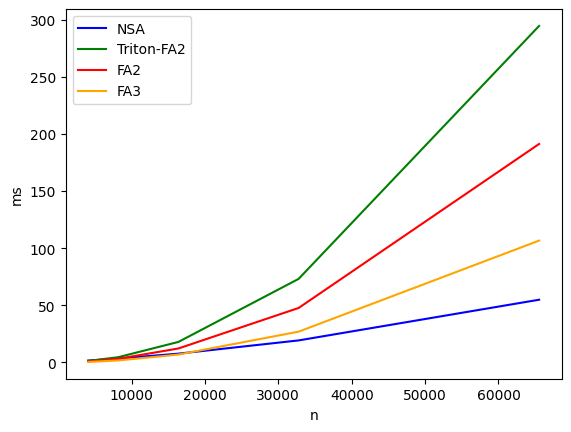

forward:
         n        NSA  Triton-FA2         FA2         FA3
0   4096.0   1.636043    1.237447    0.854760    0.433516
1   8192.0   3.369944    4.586613    3.172062    1.712960
2  16384.0   7.667904   17.924274   12.195124    6.874225
3  32768.0  19.261448   73.122749   47.660912   26.929739
4  65536.0  54.878178  294.555847  191.237671  106.627266


In [4]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * 2**i for i in range(0, 5)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'Triton-FA2', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "Triton-FA2",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16,'window_size':512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, window_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        nsa = NsaAttention(d, vd, kernel_size, stride, select_size, top_n, window_size).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: nsa(q, k, v))
    if provider == 'Triton-FA2':
        ms = triton.testing.do_bench(lambda: triton_fa2(q, k, v))
    if provider == 'FA2':
        if not HAVE_FA2:
            return 0
        ms = triton.testing.do_bench(lambda: fa2(q, k, v, causal=True))
    if provider == 'FA3':
        if not HAVE_FA3:
            return 0
        ms = triton.testing.do_bench(lambda: fa3(q, k, v, causal=True))
    return ms
benchmark.run(show_plots=True, print_data=True)

Triton autotuning for function _dq_kernel finished after 21.66s; best config selected: BLOCK_SIZE_N: 128, BLOCK_SIZE_M: 128, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _dq_kernel finished after 2.67s; best config selected: BLOCK_SIZE_N: 128, BLOCK_SIZE_M: 128, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _dq_kernel finished after 4.97s; best config selected: BLOCK_SIZE_N: 128, BLOCK_SIZE_M: 128, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _dq_kernel finished after 16.79s; best config selected: BLOCK_SIZE_N: 128, BLOCK_SIZE_M: 128, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _dq_kernel finished after 68.04s; best config selected: BLOCK_SIZE_N: 128, BLOCK_SIZE_M: 128, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;


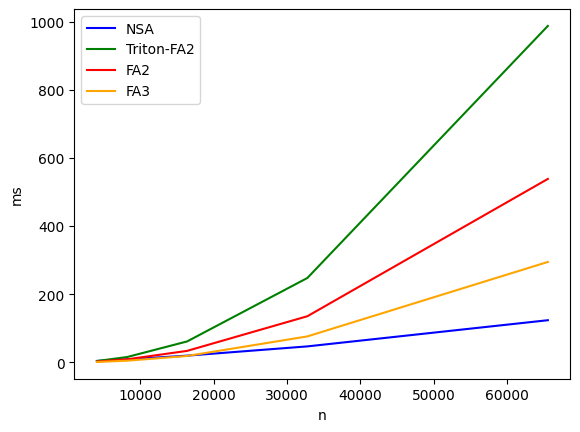

backward:
         n         NSA  Triton-FA2         FA2         FA3
0   4096.0    4.231524    4.086307    2.508782    1.380329
1   8192.0    8.861718   15.639690    8.953718    4.971749
2  16384.0   19.791449   61.520321   33.811104   18.827488
3  32768.0   46.977791  247.759003  135.482559   76.256958
4  65536.0  123.787613  987.546387  538.496399  294.824921


In [5]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * 2**i for i in range(0, 5)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'Triton-FA2', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "Triton-FA2",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16,'window_size':512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, window_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    k.requires_grad_(True)
    v.requires_grad_(True)
    dy = torch.randn(b, n, qh, vd, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        nsa = NsaAttention(d, vd, kernel_size, stride, select_size, top_n, window_size).to(device).to(dtype)
        # inplace用于测试，bwd_ind会被原地修改，改为不原地修改
        y = nsa(q, k, v, inplace=False)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    if provider == 'Triton-FA2':
        y, _ = triton_fa2(q, k, v)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    if provider == 'FA2':
        if not HAVE_FA2:
            return 0
        y = fa2(q, k, v, causal=True)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    if provider == 'FA3':
        if not HAVE_FA3:
            return 0
        y, _ = fa3(q, k, v, causal=True)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    return ms
benchmark.run(show_plots=True, print_data=True)